# Measuring the J/psi mass

In [1]:
# Required imports and setup
import os
import numpy as np
from rootpy.plotting import Hist, Canvas, set_style, get_style
from rootpy import asrootpy, log
from root_numpy import root2array, fill_hist
from ROOT import (RooFit, RooRealVar, RooDataHist, RooArgList,
                  RooVoigtian, RooAddPdf, RooPolynomial, TLatex)
style = get_style('ATLAS')
style.SetCanvasDefW(900)
style.SetCanvasDefH(600)
set_style('ATLAS')
log['/ROOT.TClassTable.Add'].setLevel(log.ERROR)

INFO:rootpy.plotting.style:using ROOT style 'ATLAS'


In [2]:
def get_masses(filename, treename='events'):
    # Get array of squared mass values selecting opposite charge events
    expr = '(e1 + e2)**2 - ((px1 + px2)^2 + (py1 + py2)^2 + (pz1 + pz2)^2)'
    m2 = root2array(filename, treename=treename,
                    branches=expr, selection='q1 * q2 == -1')
    # Remove bad events
    m2 = m2[m2 > 0]
    # Return the masses
    return np.sqrt(m2)

In [3]:
def plot_hist(hist, logy=True, logx=True):
    # A function to plot the mass values
    canvas = Canvas()
    if logy:
        canvas.SetLogy()
    if logx:
        canvas.SetLogx()
    hist.xaxis.title = 'm_{#mu#mu} [GeV]'
    hist.yaxis.title = 'Events'
    hist.Draw('hist')
    return canvas

## Fetch the data

In [4]:
if not os.path.exists('events.root'):
    !curl https://cernbox.cern.ch/index.php/s/ZE45HERahm7DeZ6/download -o events.root

## Plot the dimuon mass spectrum

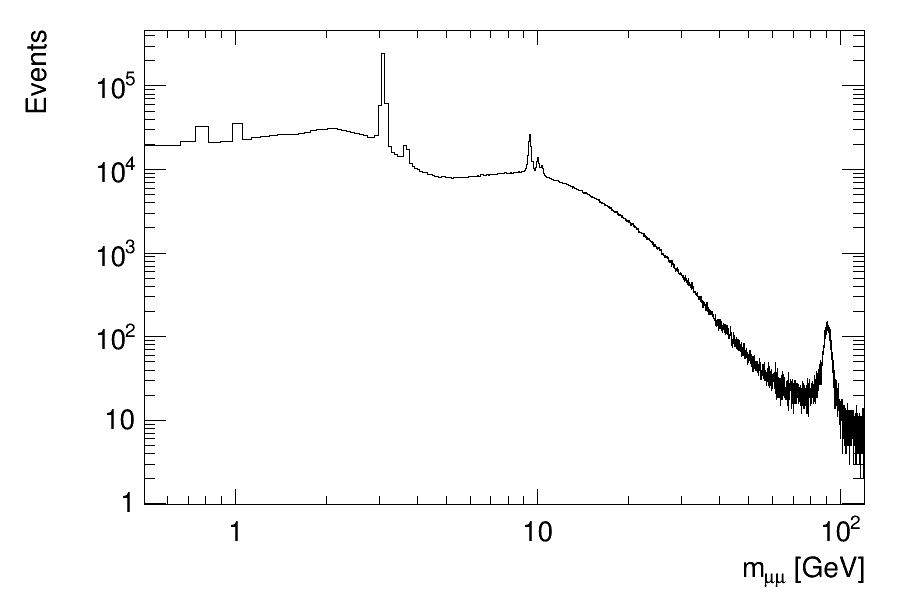

In [5]:
masses = get_masses('events.root')
mass_hist = Hist(1500, 0.5, 120)
fill_hist(mass_hist, masses)
plot_hist(mass_hist)

## Zoom in on the J/psi resonance

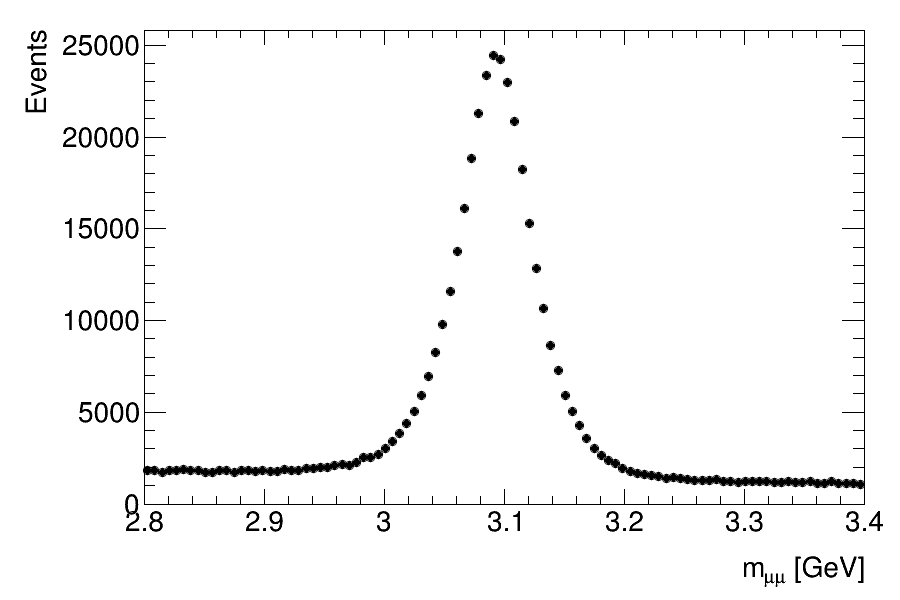

In [6]:
mass_hist_zoomed = Hist(100, 2.8, 3.4, drawstyle='EP')
fill_hist(mass_hist_zoomed, masses)
plot_hist(mass_hist_zoomed, logx=False, logy=False)

## Measure the mass

In [7]:
def fit(hist):
    hmin = hist.GetXaxis().GetXmin()
    hmax = hist.GetXaxis().GetXmax()

    # Declare observable x
    x = RooRealVar("x","x",hmin,hmax)
    dh = RooDataHist("dh","dh",RooArgList(x),RooFit.Import(hist))

    frame = x.frame(RooFit.Title("Z mass"))
    # this will show histogram data points on canvas 
    dh.plotOn(frame,RooFit.MarkerColor(2),RooFit.MarkerSize(0.9),RooFit.MarkerStyle(21))

    # Signal PDF
    mean = RooRealVar("mean","mean",3.1, 0, 5)
    width = RooRealVar("width","width",1, 0, 100)
    sigma = RooRealVar("sigma","sigma",5, 0, 100)
    voigt = RooVoigtian("voigt","voigt",x,mean,width,sigma)
    
    # Background PDF
    pol0 = RooPolynomial("pol0","pol0",x,RooArgList())
    
    # Combined model
    jpsi_yield = RooRealVar("jpsi_yield","yield of j/psi",0.9,0,1)
    model = RooAddPdf("model","pol0+gauss",RooArgList(voigt,pol0),RooArgList(jpsi_yield))

    result = asrootpy(model.fitTo(dh, RooFit.Save(True)))
    mass = result.final_params['mean'].value
    bin1 = hist.FindFirstBinAbove(hist.GetMaximum()/2)
    bin2 = hist.FindLastBinAbove(hist.GetMaximum()/2)
    hwhm = (hist.GetBinCenter(bin2) - hist.GetBinCenter(bin1)) / 2
    # this will show fit overlay on canvas
    model.plotOn(frame,RooFit.LineColor(4))

    # Draw all frames on a canvas
    canvas = Canvas()
    frame.GetXaxis().SetTitle("m_{#mu#mu} [GeV]")
    frame.GetXaxis().SetTitleOffset(1.2)
    frame.Draw()
    
    # Draw the mass and error label
    label = TLatex(0.6, 0.8, "m_{{J/#psi}} = {0:.2f} #pm {1:.2f} GeV".format(mass, hwhm))
    label.SetNDC()
    label.Draw()
    
    return canvas

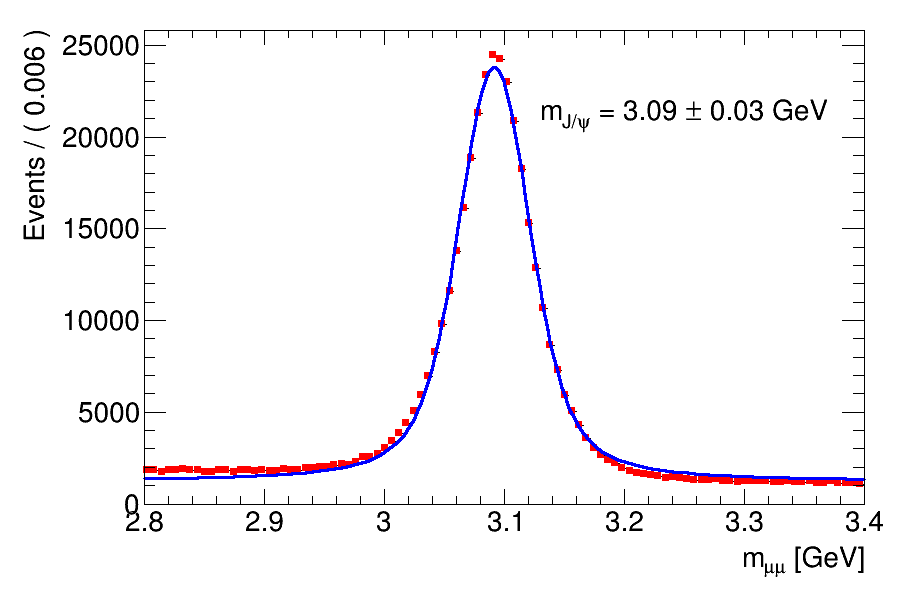

In [8]:
fit(mass_hist_zoomed)

* These events were extracted from the CMS Mu Primary Dataset on the CERN Open Data Portal: http://opendata.cern.ch/record/14. 
* Thanks to http://openstack.cern.ch for providing a CernVM running SL5 where I could set up CMSSW 4.2.8 and to https://github.com/tpmccauley/dimuon-filter for generating the CSV from CMS AODs.